# Маркетинговый анализ развлекательного приложения Procrastinate Pro+

Наша компания является разработчиком  развлекательного приложения Procrastinate Pro+. Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Необходимо разобраться в причинах и помочь компании выйти в плюс.

Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:

- лог сервера с данными об их посещениях,
- выгрузка их покупок за этот период,
- рекламные расходы.

Необходимо изучить:

- откуда приходят пользователи и какими устройствами они пользуются,
- сколько стоит привлечение пользователей из различных рекламных каналов;
- сколько денег приносит каждый клиент,
- когда расходы на привлечение клиента окупаются,
- какие факторы мешают привлечению клиентов.

План работ:

- загрузка данных и подготовка к анализу
- подготовка функций для расчета
- исследовательский анализ данных
- маркетинг
- оценка окупаемости рекламы
- выводы и рекомендации


### Загрузка и подготовка данных к анализу

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [2]:
visits, orders, costs = (
    pd.read_csv('datasets/visits_info_short.csv'),  # журнал сессий
    pd.read_csv('datasets/orders_info_short.csv'),  # покупки
    pd.read_csv('datasets/costs_info_short.csv'),  # траты на рекламу
)

In [3]:
visits.head()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [4]:
orders.head()

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [5]:
costs.head()

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [6]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [8]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [9]:
visits.duplicated().sum() # ищем явные дубликаты

0

In [10]:
orders.duplicated().sum() # ищем явные дубликаты

0

In [11]:
costs.duplicated().sum() # ищем явные дубликаты

0

Пропуски в столбцах отсутствуют, явных дубликатов тоже нет. Но названия столбцов не соответствуют правилам "хорошего тона", переименую их.

In [12]:
visits.columns = map(str.lower, visits.columns)
orders.columns = map(str.lower, orders.columns)
costs.columns = map(str.lower, costs.columns)

In [13]:
visits = visits.rename(columns={'user id': 'user_id', 'session start': 'session_start', 'session end': 'session_end'})
orders = orders.rename(columns={'user id': 'user_id', 'event dt': 'event_dt'})

Сменю форматы у столбцов с датами и временем

In [14]:
# преобразование данных о времени
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

In [15]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


In [16]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


In [17]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


Переименование столбцов и смена формата прошли успешно

### Функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

Функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [18]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())


    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    costs = costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    costs['acquisition_cost'] = costs['costs'] / costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [19]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [20]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [21]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [22]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [23]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [24]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [25]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

### Исследовательский анализ данных

- Составить профили пользователей. Определить минимальную и максимальную даты привлечения пользователей.
- Выяснить, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построить таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнайть, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построить таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучить рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Построить таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

Получу профили пользователей. Для этого вызовем функцию get_profiles(), передав ей данные о посещениях, покупках и тратах на рекламу 

In [26]:
profiles = get_profiles(visits, orders, costs)
profiles.head(5)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


Определяю минимальную и максимальную даты привлечения пользователей

In [27]:
min_analysis_date = profiles['dt'].min()
observation_date = profiles['dt'].max() 

In [28]:
min_analysis_date

datetime.date(2019, 5, 1)

In [29]:
observation_date

datetime.date(2019, 10, 27)

**Минимальная дата привлечения пользователей - 1 мая 2019 года.**

**Максимальная дата привлечения пользователей - 27 октября 2019 года**

Выясню из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построю таблицу, отражающую количество пользователей и долю платящих из каждой страны.

In [30]:
region_payer = pd.DataFrame()
region_payer['users_cnt'] = profiles.groupby('region')['user_id'].count()
region_payer['payer_users_cnt'] = profiles.query('payer == True').groupby('region')['user_id'].count()
region_payer['share'] = 100*(region_payer['payer_users_cnt'] / region_payer['users_cnt'])
region_payer.sort_values(by='share', ascending=False).style.format({'share': '{:.1f}%'})

,users_cnt,payer_users_cnt,share
region,,,
United States,100002,6902,6.9%
Germany,14981,616,4.1%
UK,17575,700,4.0%
France,17450,663,3.8%


Больше всего пользователей приходит из США, так же на эту страну приходится больше всего платящих пользователей.

Узнаю, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построю таблицу, отражающую количество пользователей и долю платящих для каждого устройства.

In [31]:
device_payer = pd.DataFrame()
device_payer['users_cnt'] = profiles.groupby('device')['user_id'].count()
device_payer['payer_users_cnt'] = profiles.query('payer == True').groupby('device')['user_id'].count()
device_payer['share'] = 100*(device_payer['payer_users_cnt'] / device_payer['users_cnt'])
device_payer.sort_values(by='share', ascending=False).style.format({'share': '{:.1f}%'})

,users_cnt,payer_users_cnt,share
device,,,
Mac,30042,1912,6.4%
iPhone,54479,3382,6.2%
Android,35032,2050,5.9%
PC,30455,1537,5.0%


Пользователи используют Mac, iPhone, Android, PC. Больше всего пользователей приходится на iPhone и платящих пользователей в абсолютном выражении тоже, но конверсия из пользователей в платящих выше у тех кто использует Mac.	

Изучаю рекламные источники привлечения и определяю каналы, из которых пришло больше всего платящих пользователей. Строю таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [32]:
channel_payer = pd.DataFrame()
channel_payer['users_cnt'] = profiles.groupby('channel')['user_id'].count()
channel_payer['payer_users_cnt'] = profiles.query('payer == True').groupby('channel')['user_id'].count()
channel_payer['share'] = 100*(channel_payer['payer_users_cnt'] / channel_payer['users_cnt']) 
channel_payer.sort_values(by='share', ascending=False).style.format({'share': '{:.1f}%'})

,users_cnt,payer_users_cnt,share
channel,,,
FaceBoom,29144,3557,12.2%
AdNonSense,3880,440,11.3%
lambdaMediaAds,2149,225,10.5%
TipTop,19561,1878,9.6%
RocketSuperAds,4448,352,7.9%
WahooNetBanner,8553,453,5.3%
YRabbit,4312,165,3.8%
MediaTornado,4364,156,3.6%
LeapBob,8553,262,3.1%


Больше всего пользователей приходит из канала organic, это бесплатные для нас пользователи, но у них самая низкая конверсия в платящих, всего 2,1%. На втором месте по привлечению стоит FaceBoom, но здесь наоборот максимальное количество пользователей становятся платящими 12,2%

ВЫВОД по п.3: В таблицах приведены данные за период с 1 мая 2019 года по 27 октября 2019 года. Больше всего платящих пользователей приходится на США с большим отрывом от остальных стран, стоит состредоточится на этой стране, так же больше всего платящих пользователей среди владельцев iPhone, канал с максимальной конвертацией FaceBoom.

### Маркетинг

- Посчитать общую сумму расходов на маркетинг.
- Выяснить, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Построить визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. 
- Узнать, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. 

Посчитаю общую сумму расходов на маркетинг.

In [33]:
print('Общая сумма расходов на маркетинг составила:', costs['costs'].sum().round())

Общая сумма расходов на маркетинг составила: 105497.0


Выясню, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.

In [34]:
channel_costs = pd.DataFrame()
channel_costs['costs'] = costs.groupby('channel')['costs'].sum()
channel_costs['share'] = 100*(channel_costs['costs'] / costs['costs'].sum().round()) 
channel_costs.sort_values(by='costs', ascending=False)

,costs,share
channel,,
TipTop,54751.30,51.898443
FaceBoom,32445.60,30.754998
WahooNetBanner,5151.00,4.882603
AdNonSense,3911.25,3.707451
OppleCreativeMedia,2151.25,2.039158
RocketSuperAds,1833.00,1.737490
LeapBob,1797.60,1.703935
lambdaMediaAds,1557.60,1.476440
MediaTornado,954.48,0.904746


Самые большие расходы в каналах TipTop и FaceBoom (82% всего рекламного бюджета). Самыйе маленькие YRabbit	и MediaTornado

Построю визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. Отражу это на одном графике.

In [35]:
costs['month']=pd.DatetimeIndex(costs['dt']). month
costs['week']=pd.DatetimeIndex(costs['dt']). week

C:\Users\bellocal\AppData\Local\Temp\ipykernel_33332\712536115.py:2: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  costs['week']=pd.DatetimeIndex(costs['dt']). week


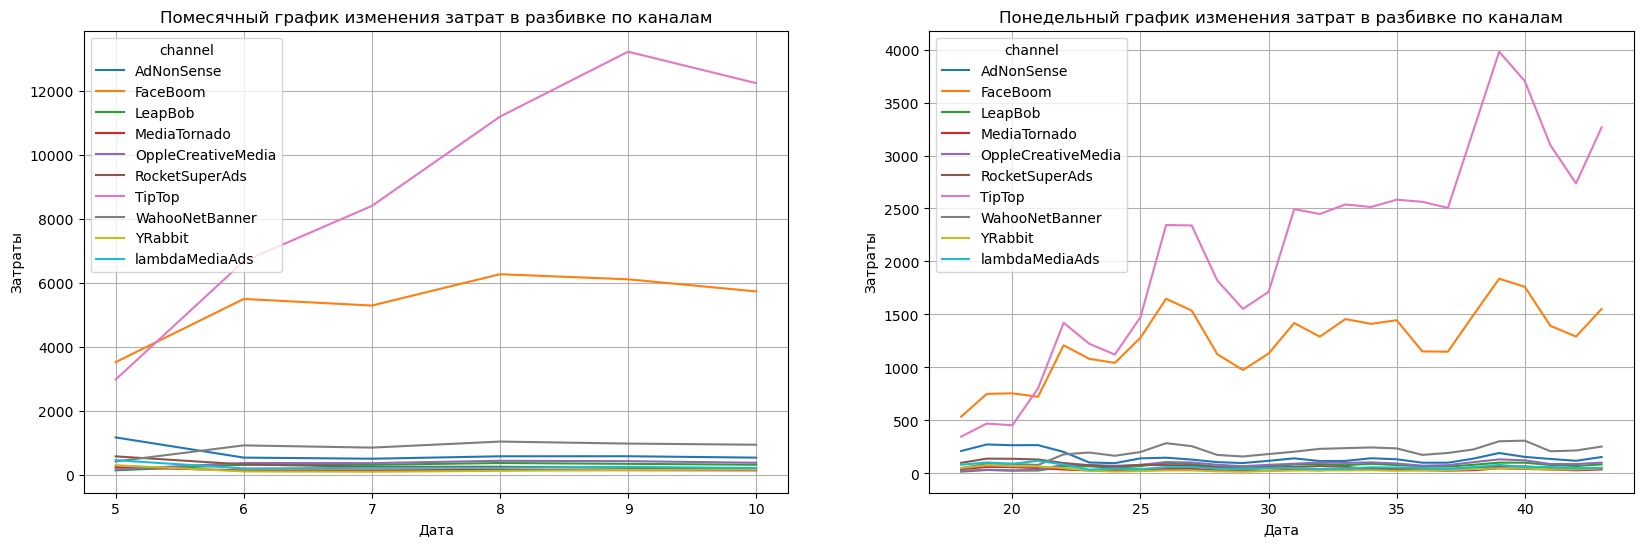

In [36]:
plt.figure(figsize=(20, 6))  # задаём размер сетки
filtered_data = costs.pivot_table(
        index='month', columns='channel', values='costs', aggfunc='sum'
    )
filtered_data.plot(                                             
           grid=True,
ax = plt.subplot(1, 2, 1))
plt.title('Помесячный график изменения затрат в разбивке по каналам')
plt.xlabel('Дата')
plt.ylabel('Затраты')


filtered_data_w = costs.pivot_table(
        index='week', columns='channel', values='costs', aggfunc='sum'
    )
filtered_data_w.plot(                                             
           grid=True,
ax = plt.subplot(1, 2, 2))

plt.title('Понедельный график изменения затрат в разбивке по каналам')
plt.xlabel('Дата')
plt.ylabel('Затраты')
plt.show()

Из обоих графиков видно, что в начале компания тратила больше на канал FaceBoom, но в июне ситуация поменялась и лидером по затратам стал канал TipTop, при этом затраты на этот канал росли значительно быстрее чем на FaceBoom. В целом с мая по конец октября затраты на рекламу выросли в несколько раз. Драйверами роста стали каналы TipTop и FaceBoom. График с помесячной разбивкой более сглаженный, в недельном видно что затраты производились не равномерно.

Узнаю, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Использую профили пользователей.

*CAC — стоимость привлечения одного клиента. Сумма денег, в которую компании обходится каждый новый клиент. В сущности, CAC — это
инвестиции в маркетинг. CAC = Расходы на рекламу / Размер когорты .

In [37]:
#Посмотрим на CAC для каждого источника трафика.
cac_by_channel = pd.DataFrame()
# уберём органических пользователей:
profiles = profiles.query('channel != "organic"')
cac_by_channel['acquisition_cost_mean'] = profiles.groupby('channel')['acquisition_cost'].mean()
cac_by_channel.sort_values(by='acquisition_cost_mean', ascending=False).style.format({'acquisition_cost_mean': '{:.2f}'})

,acquisition_cost_mean
channel,
TipTop,2.80
FaceBoom,1.11
AdNonSense,1.01
lambdaMediaAds,0.72
WahooNetBanner,0.60
RocketSuperAds,0.41
OppleCreativeMedia,0.25
YRabbit,0.22
MediaTornado,0.22


In [38]:
print('Средний CAC на пользователя проекта:', profiles['acquisition_cost'].mean())

Средний CAC на пользователя проекта: 1.127481323942928


Самым дорогим каналом в части затрат на одного пользователя оказался TipTop, FaceBoom и AdNonSense дешевле более чем в два раза.
CAC канала Tip Top в 2,5 раза выше чем среднее по проекту, по всем остальным каналам ниже среднего. Нам очень дорого стоят пользователи канала Tip Top

ВЫВОД по п.4: Лидерами по затратам на маркетинг являются каналы TipTop и FaceBoom, при этом они лидируют по затратам в абсолютном выражении и по затратам на одного пользователя, пока нельзя сказать окупаются данные затраты или нет.

### Оцените окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируйте окупаемость рекламы. Считайте, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

- Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.
- Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответьте на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

Напишите вывод, опишите возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.

In [39]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 

Анализирую окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.

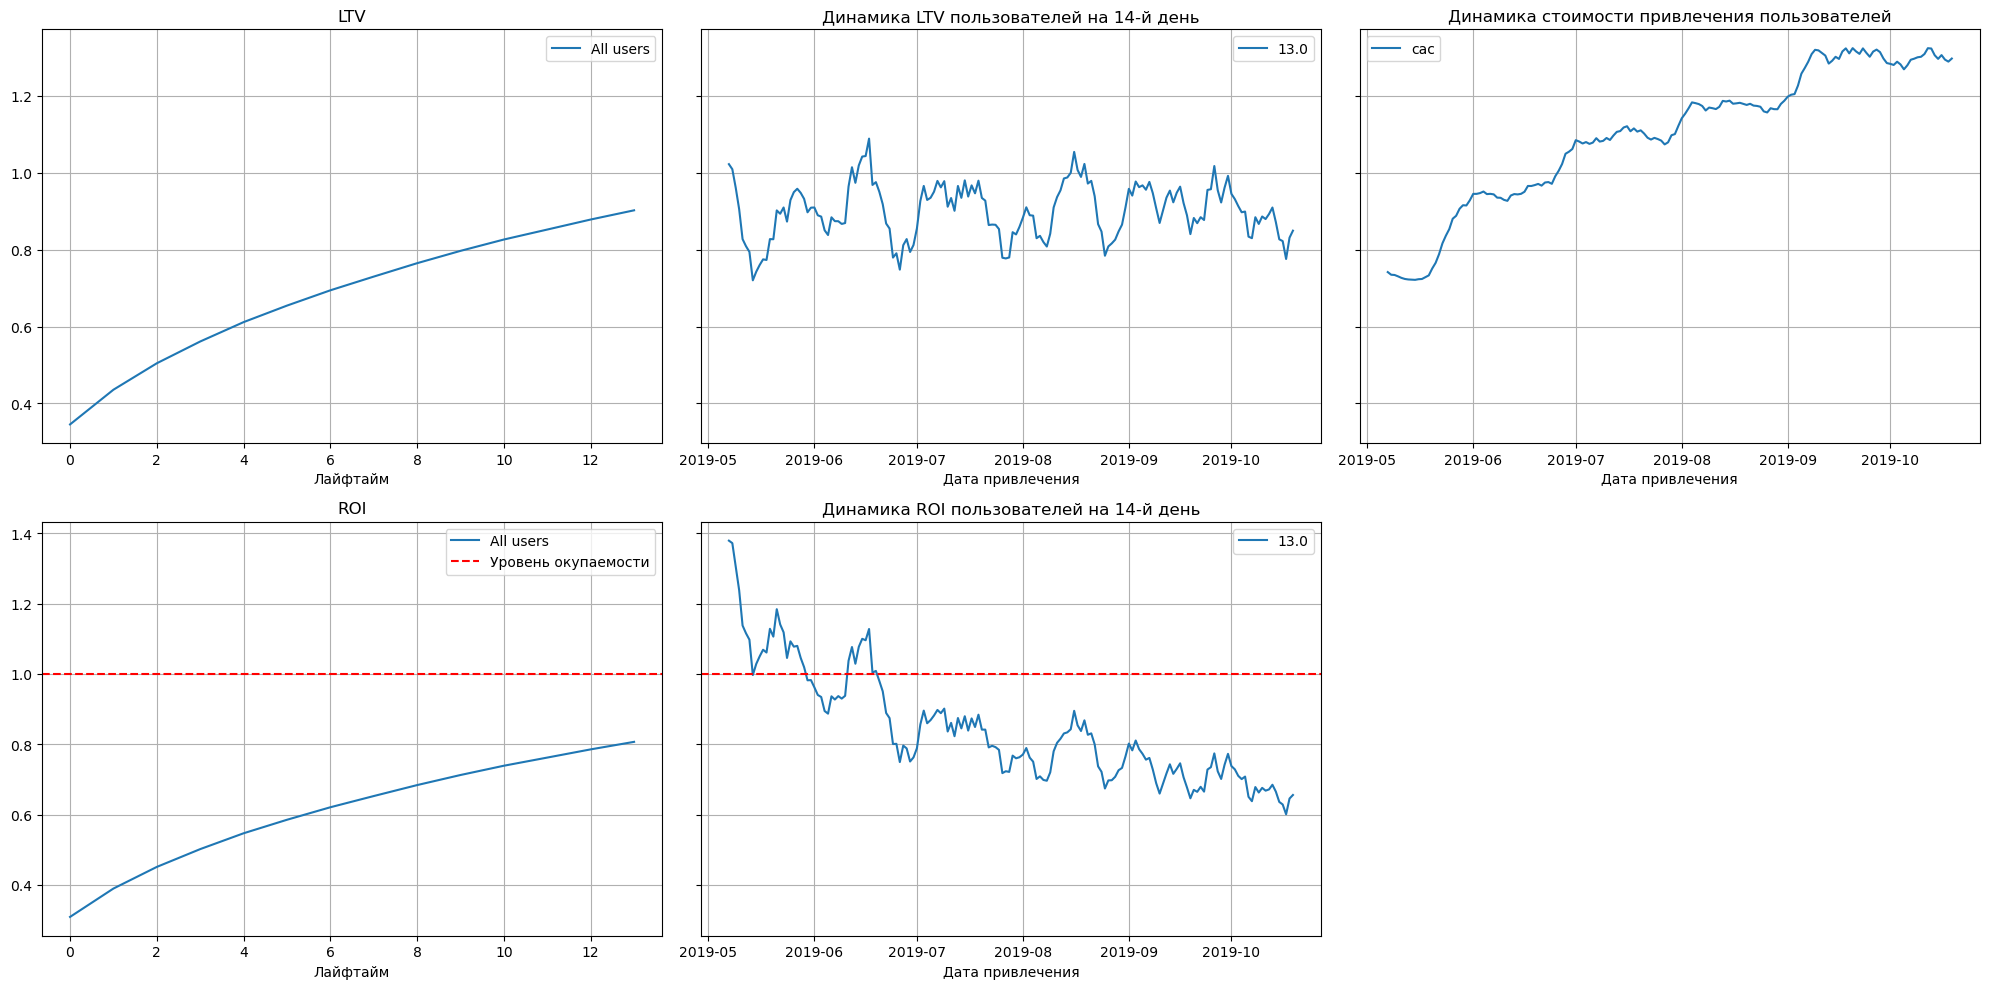

In [40]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

По графикам можно сделать такие выводы:
LTV подвержен сезонности, но стабилен
Реклама не окупается. ROI в конце второй недели — чуть выше 80%.
CAC растет, рекламный бюджет увеличивается, что было замечено и ранее.
Пользоваели перестают окупатся в июне

Проверю конверсию пользователей и динамику её изменения и удержание пользователей. Построю и изучу графики конверсии и удержания (для начала посмотрю графики по всем данным).

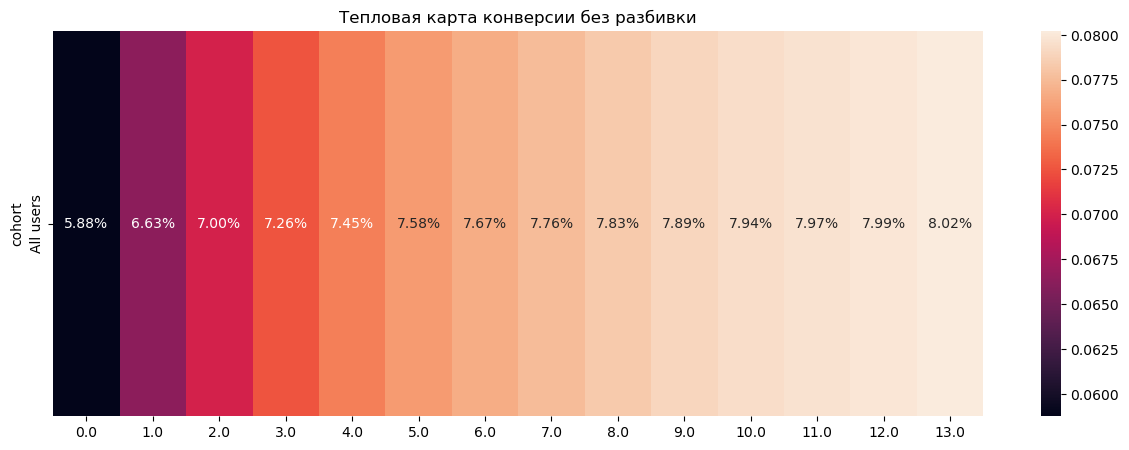

In [41]:
# считаем конверсию без параметра dimensions
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, datetime(2019, 11, 1).date(), 14
)

# строим хитмэп по таблице конверсии
plt.figure(figsize=(15, 5))
sns.heatmap(conversion.drop(columns=['cohort_size']), annot=True, fmt='.2%')
plt.title('Тепловая карта конверсии без разбивки')
plt.show() 

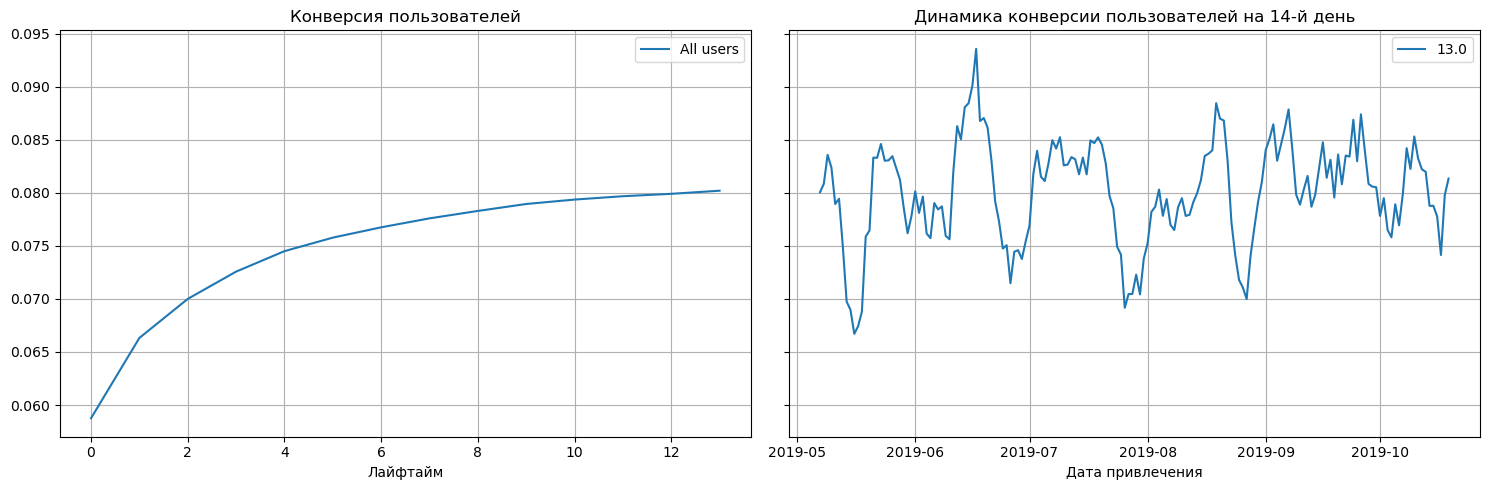

In [42]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days
)
plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Динамика конверсии примерно одинаковая на протяжении нескольких месяцев, причем с сентября конверсия стала стабильнее

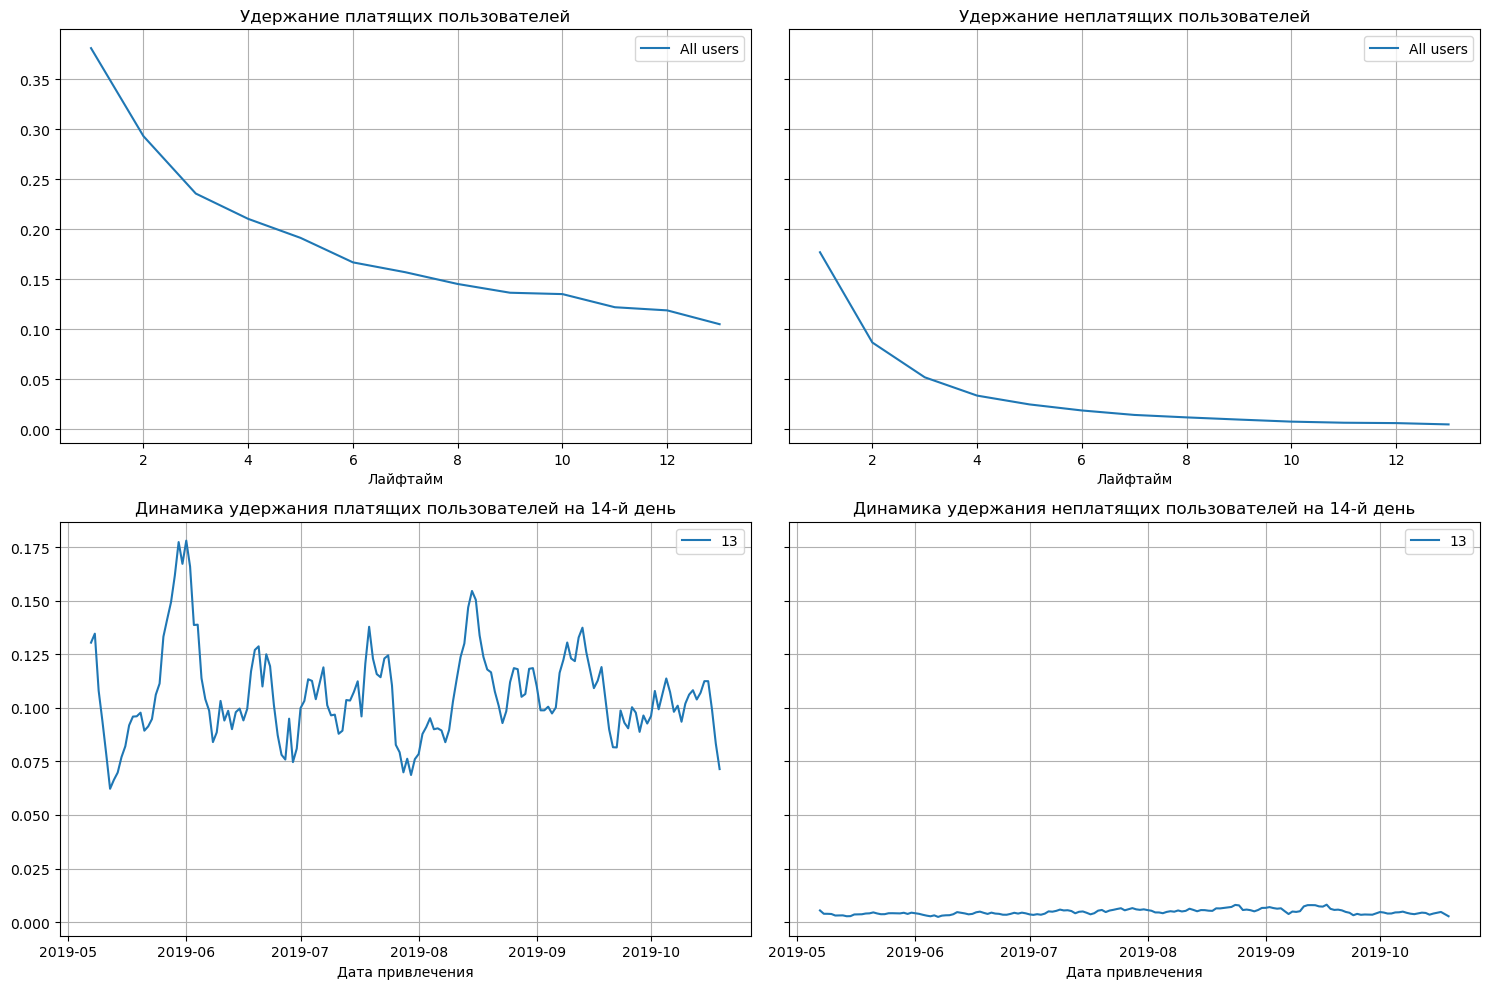

In [43]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Удержание платящих пользователей выше чем неплатящих, динамика удержания так же как и динамика конверсии стабилизировалась к сентябрю

Теперь нужно проанализировать окупаемость рекламы с разбивкой по устройствам. Пострить графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

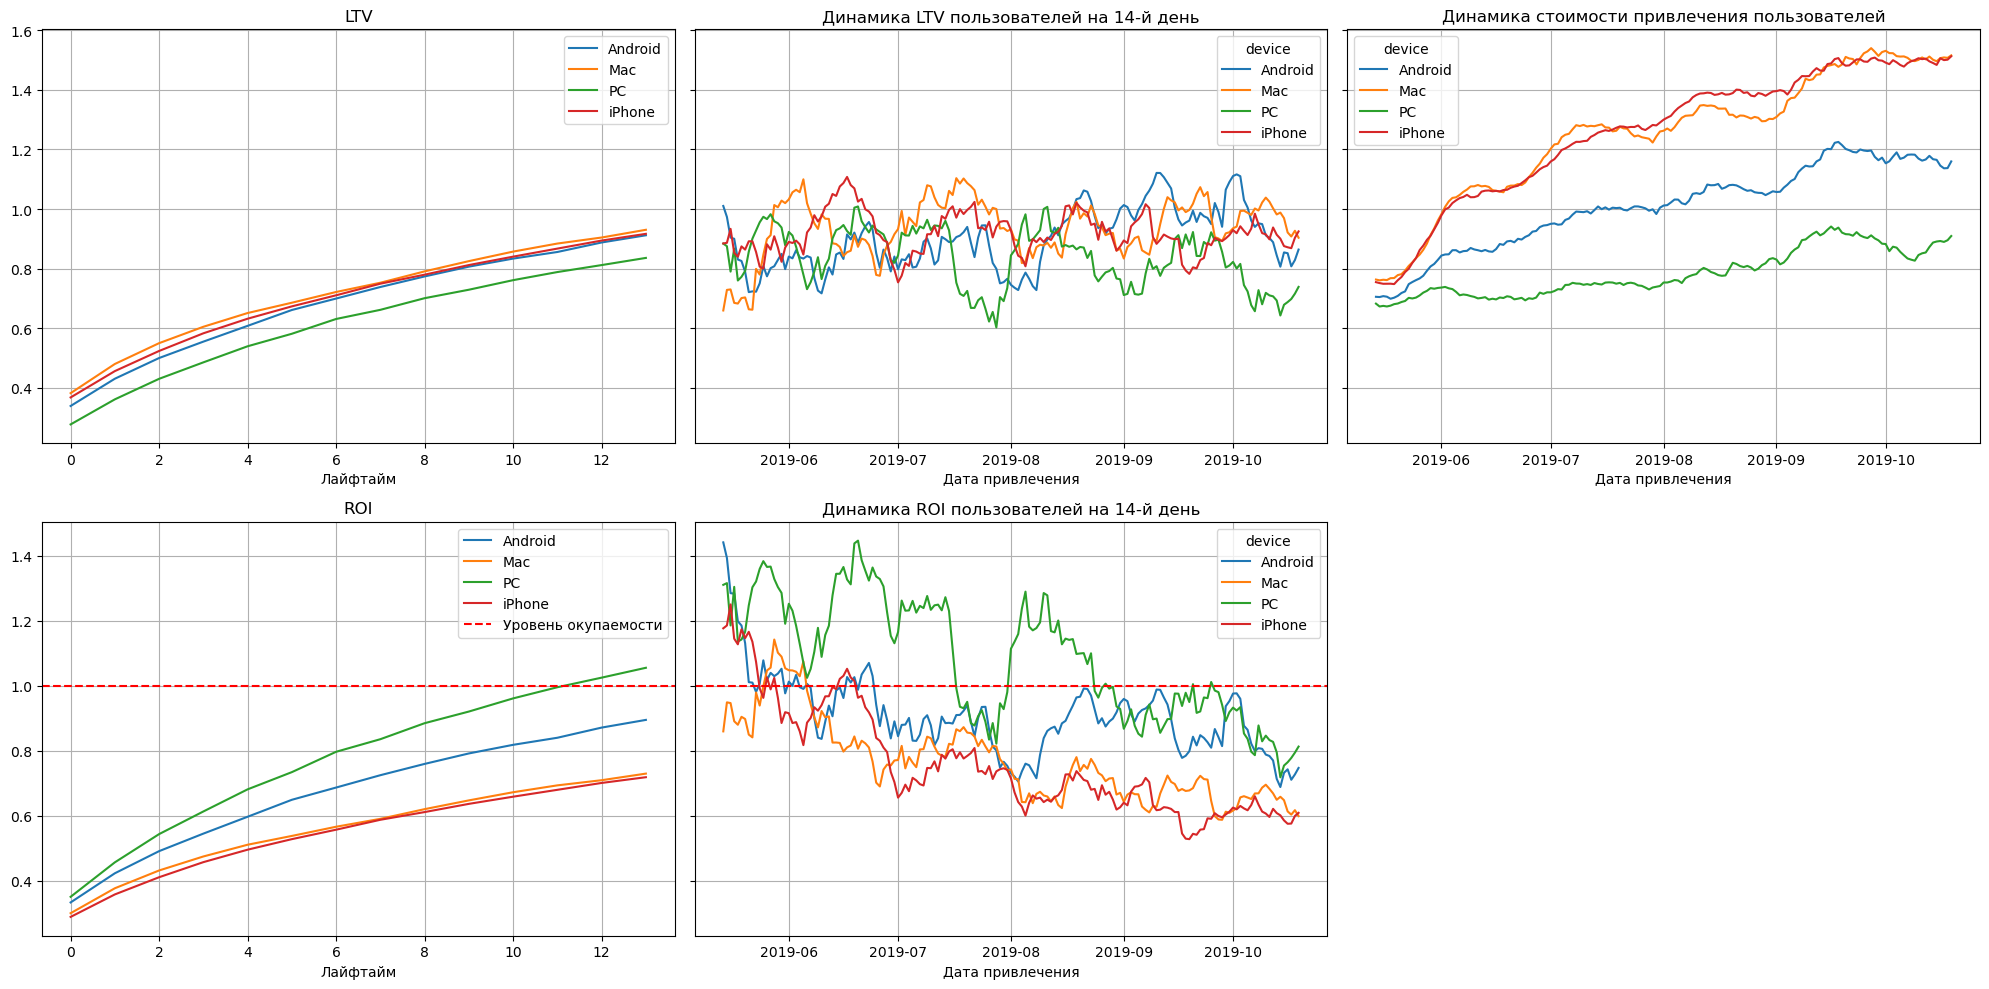

In [44]:
# смотрим окупаемость с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Из графиков видно, что самый низкий LTV приходится на пользователей PC, так же у этих пользователей самая нестабильная динамика.

Очень быстро растет стоимость привлечения пользователей Mac и iPhone при том что их LTV находится на уровне пользователей Android. 

На окупаемость напротив выходят только пользователи PC, пользователи Mac и iPhone в которых мы вложили больше всего денег не окупаются. Кроме того динамика ROI отрицательная 

Посмотрим что происходит с  окупаемость рекламы с разбивкой по странам. Построю графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

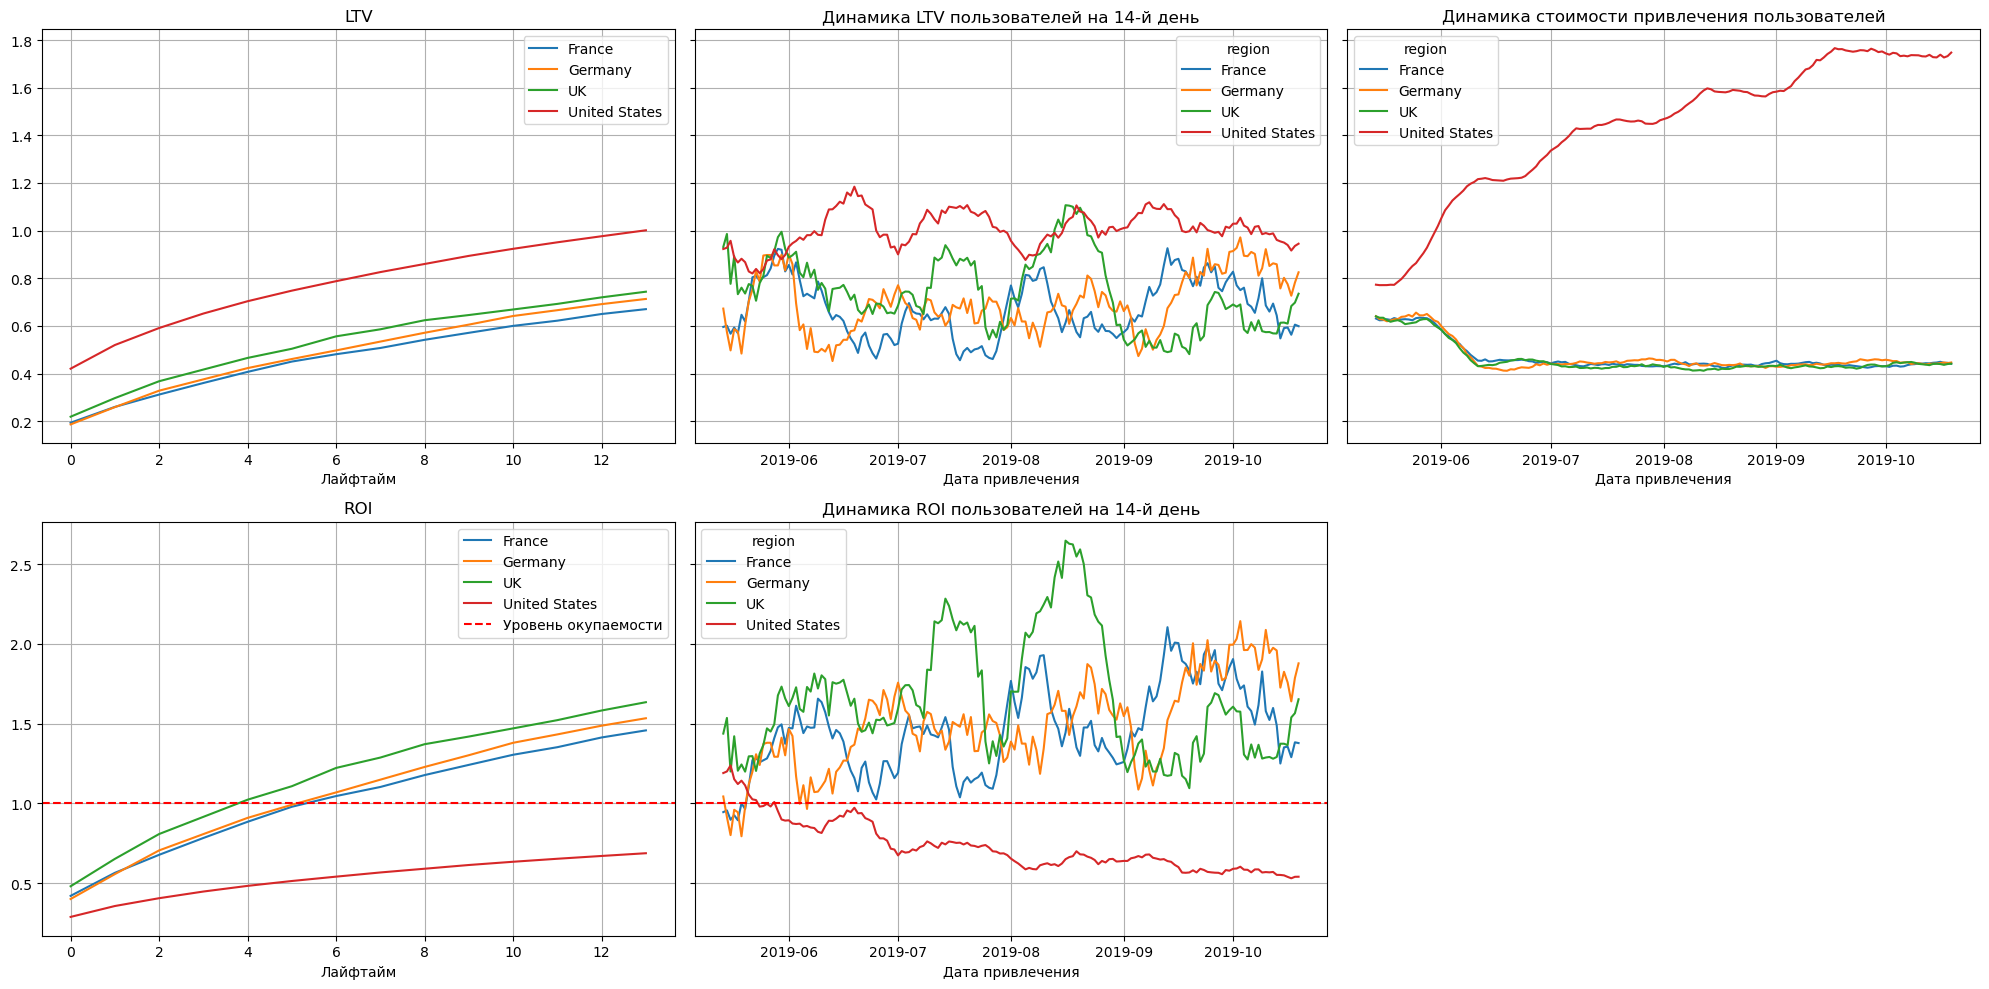

In [45]:
# смотрим окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Похоже удалось найти зацепку. Наилучший LTV показывают пользователи из США (их LTV в два раза выше пользователей из других стран) и видимо наши маркетологи увлеклись сделав на них ставку, рекламный бюджет примерно с конца мая увеличивался для США и уменьшался для остальных регионов, в результате ROI с 4-5 для для всех регионов выше 1 кроме США, США не выходят в плюс на горизонте 14 дней и динамика для США только ухудшается. 

Проанализирую окупаемость рекламы с разбивкой по рекламным каналам. Построю графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

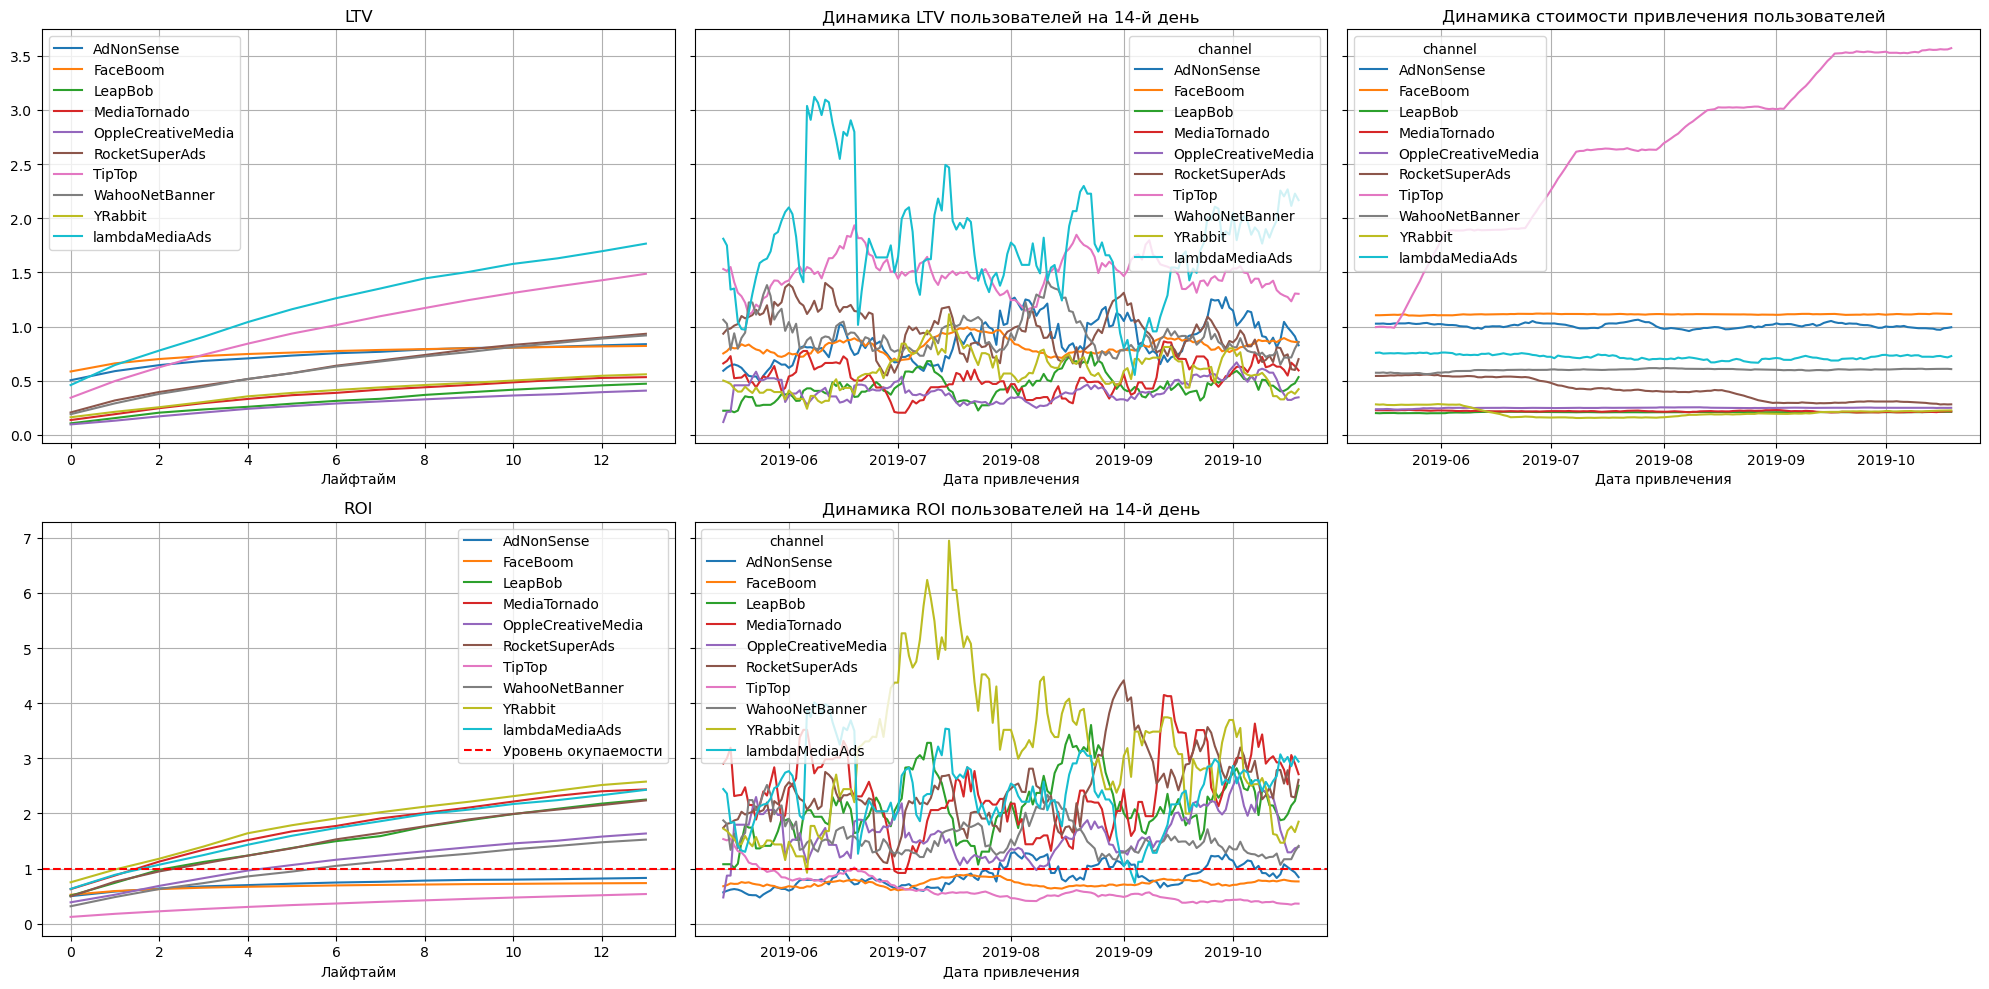

In [46]:
# смотрим окупаемость с разбивкой по источникам привлечения

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Самый высокий LTV у каналов labdaMediaAds и Tip Top, при этом labdaMediaAds является самым не стабильным, У канала Tip Top очень высокая динамика стоимости привлечения и как результат пользователи данного канала не окупаются. Быстрее всего окупается YRabbit.
Не окупаются к концу 2 недели пользователи из каналов: TipTop, FaceBoom, AdNonSense

ВЫВОД: Реклама направленная на привлечение пользователей в целом не окупается ROI на 14 день ниже 1 и имеет отрицательную динамику.

Лучше всего окупаются пользователи PC, ROI таких пользователей поднимается выше 1 после 11 дня, но при этом пользователи всех устройств имеют отрицательную динамику ROI. 

Среди стран самую низкую окупаемость имеют пользователи из США, а самым дорогим и не оправдывающим себя каналом является TipTop.

Вероятнее всего маркетологи заметив потенциял пользователей из США сосредоточились именно на них и начали увеличивать рекламный бюджет в популярном для США канале TipTop, но такая стратегия себя не оправдала. Для выравнивания ситуации необходимо снизить рекламный бюджет в каналах не приносящих прибыли, излишки можно перенаправить в перспективные каналы, такие как YRabbit и т.п. Кроме того возможно стоит провести переговоры с владельцами канала TipTop и добится снижения стоимости на одного пользователя, рассчитав точку безубыточности канала, если владельцы канала не захотят терять клиента, то они вполне могут сделать существенную скидку видя доказательства несостоятельности рекламной кампании. 

Для того что бы написать финальные выводы посмотрю конверсию пользователей в разных разбивках

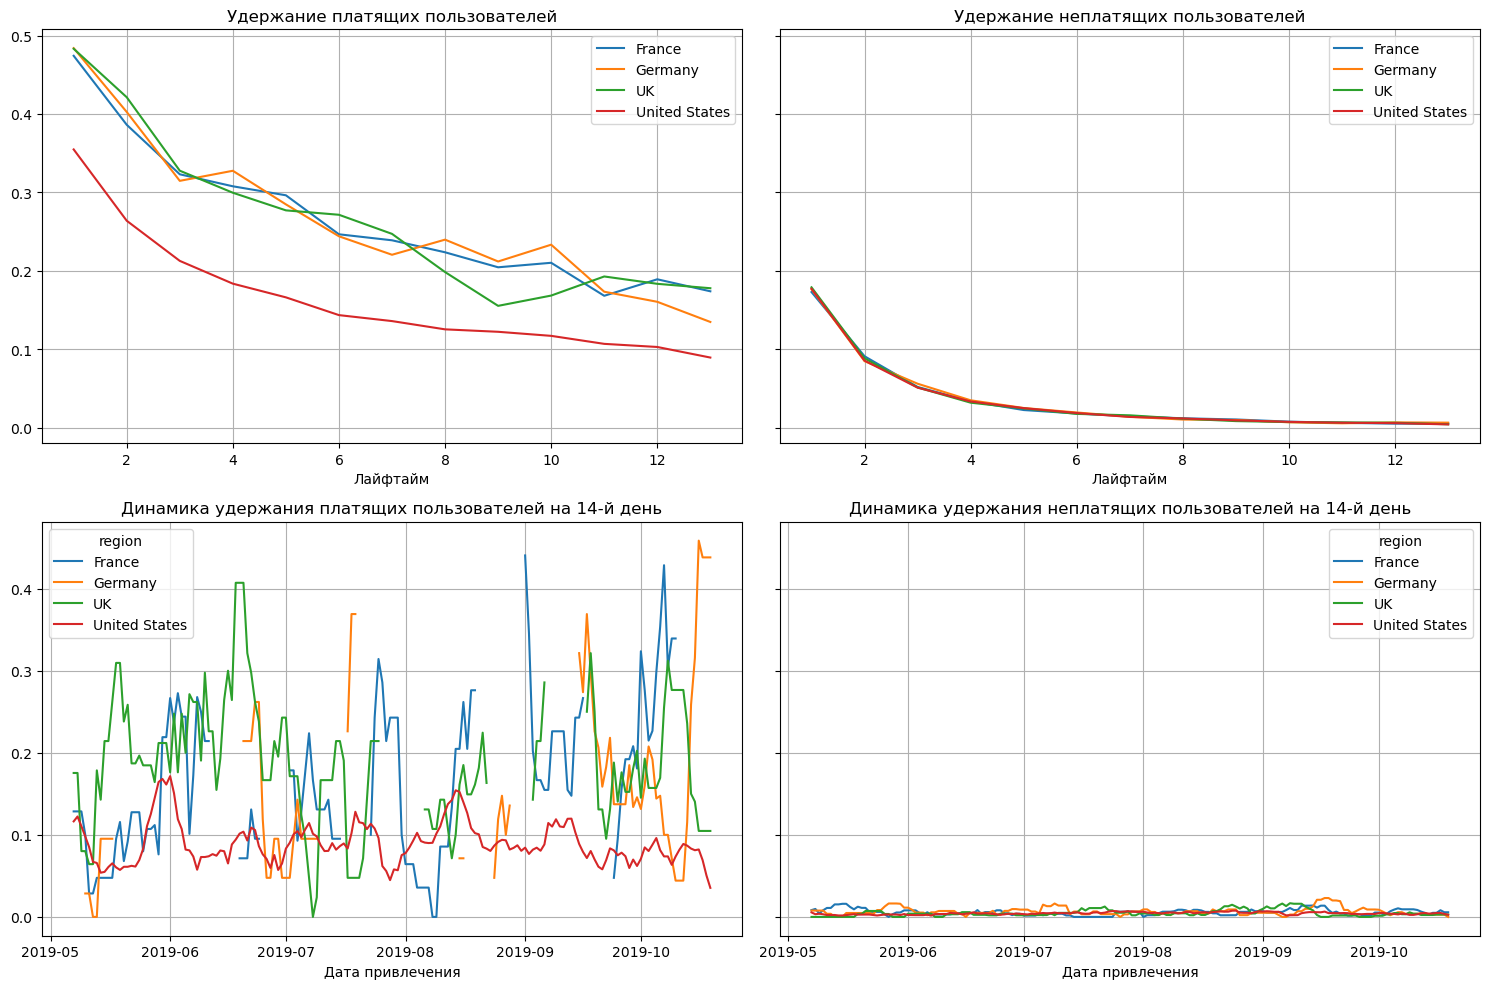

In [47]:
# смотрим удержание с разбивкой по странам
dimensions = ['region']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Самое низкое удержание платящих пользователей наблюдается для США, при этом динамика подвержена сезонности, но остается на одном уровне

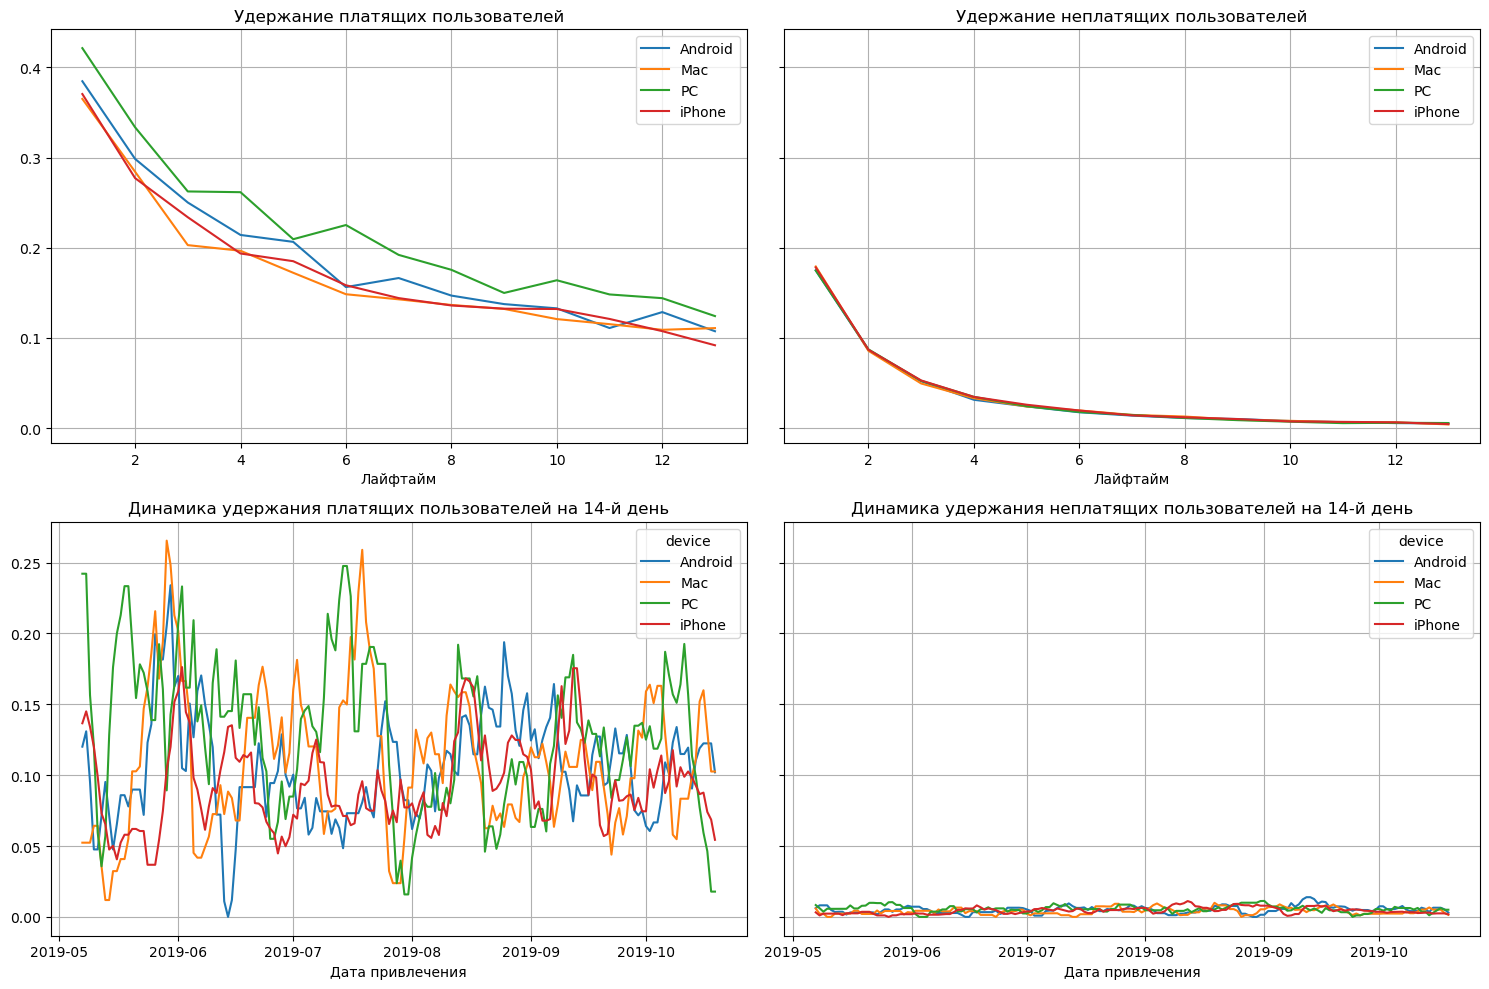

In [48]:
# смотрим удержание с разбивкой по устройствам
dimensions = ['device']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Удерживаются лучше всего пользователи PC, но большого разброса не наблюдается, динамика стабильная

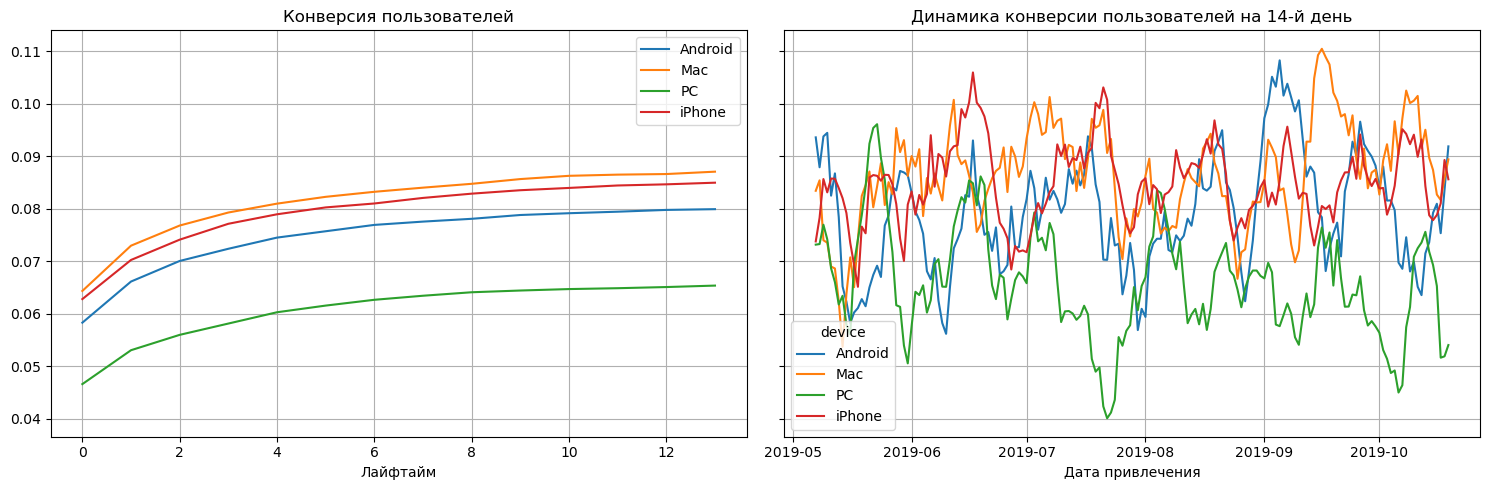

In [49]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)
plot_conversion(conversion_grouped, conversion_history, horizon_days)

У пользователей PC самая низкая конверсия, лучшая конверсия у пользователей Mac

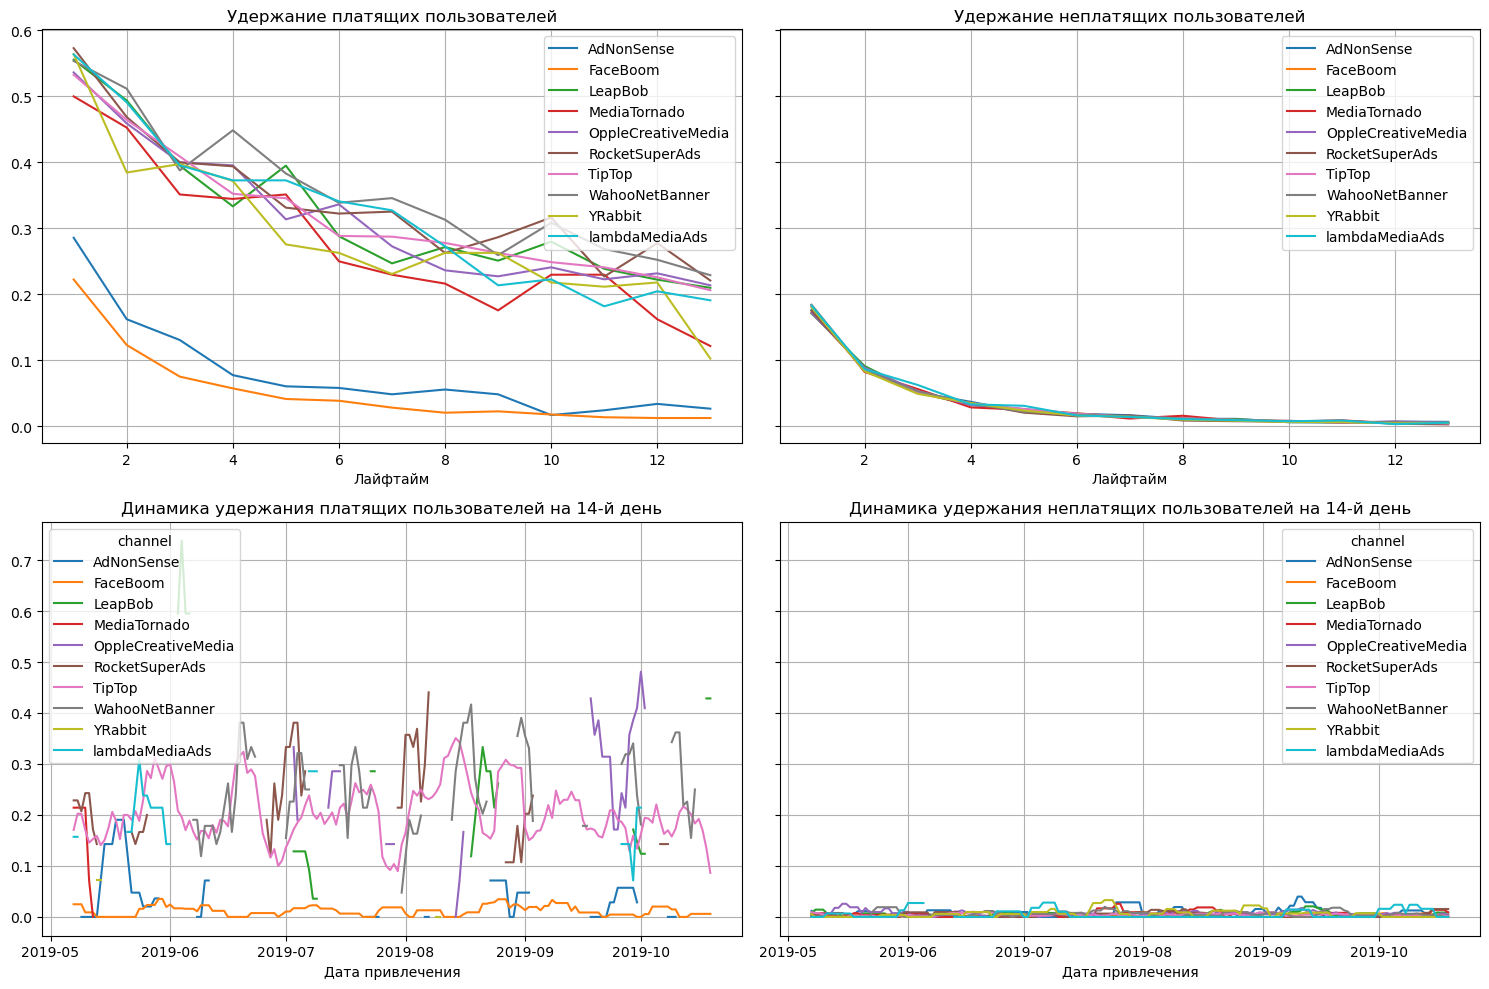

In [50]:
# смотрим удержание с разбивкой по каналам
dimensions = ['channel']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Очень плохо удерживаются пользователи каналов FaceBoom и AdNonSence при стабильной динамике. Каналы с наилучшим удержании сложно выделить так как кривые постоянно пересекаются

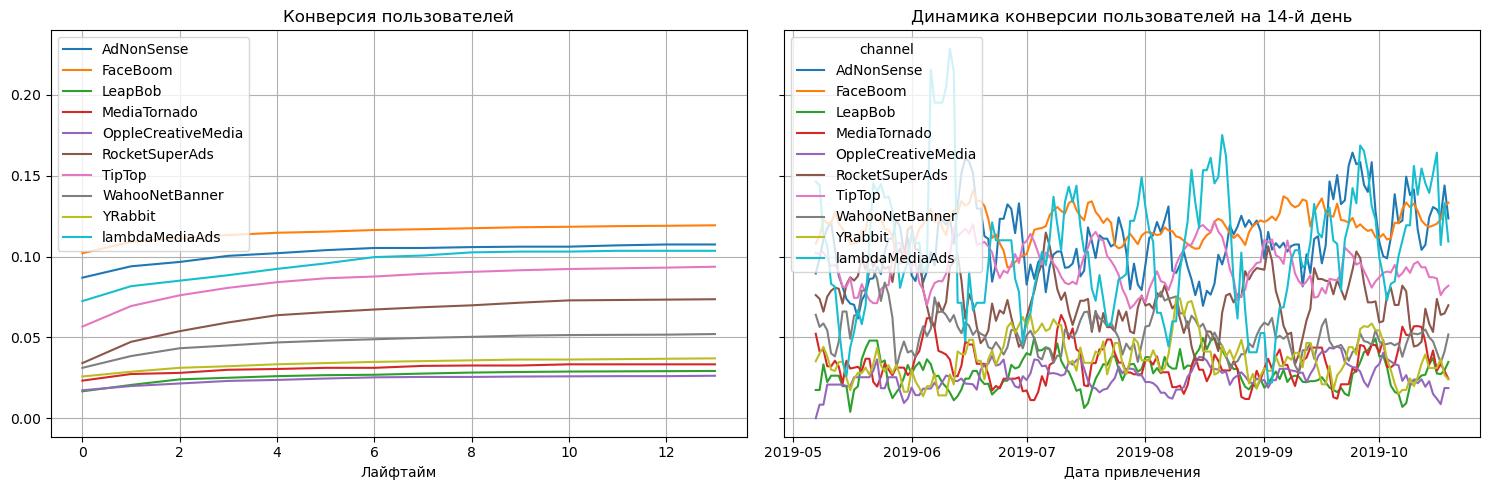

In [51]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)
plot_conversion(conversion_grouped, conversion_history, horizon_days)

Наилучшую конверсию показывают каналы FaceBoom и AdNonSence именно те что хуже всего удерживают пользователей в дальнейшем

Удержание неплатящих пользователей нас мало интересует и оно примерно одинакого во всех разбивках. С платящими пользователями наблюдается интересная картина. Хуже всего удерживаются пользователи из США, по устройствам iPhone и Mac, но с устройствами ситуация ровнее чем со странами и каналами привлечения. Очень плохо удерживаются пользователи каналов FaceBoom и AdNonSence

In [52]:
# Как связаны страны и каналы привлечения?
region_channels = (
    profiles[profiles['payer']==True].pivot_table(index='channel', 
                                              columns = 'region', 
                                              values = 'user_id', 
                                              aggfunc='count')
    .reset_index()
    .sort_values('United States')
    .query('channel != "organic"')
)
region_channels

region,channel,France,Germany,UK,United States
3,MediaTornado,NaN,NaN,NaN,156.0
8,YRabbit,NaN,NaN,NaN,165.0
5,RocketSuperAds,NaN,NaN,NaN,352.0
6,TipTop,NaN,NaN,NaN,1878.0
1,FaceBoom,NaN,NaN,NaN,3557.0
0,AdNonSense,150.0,142.0,148.0,NaN
2,LeapBob,90.0,69.0,103.0,NaN
4,OppleCreativeMedia,80.0,64.0,89.0,NaN
7,WahooNetBanner,152.0,148.0,153.0,NaN
9,lambdaMediaAds,82.0,67.0,76.0,NaN


Видно что каналы Европы и США не пересекаются (кроме органика)

### Выводы

- Выделить причины неэффективности привлечения пользователей.
- Сформулировать рекомендации для отдела маркетинга.

Причиной неэффективности привлечения пользователей является несбалансированный по каналам и странам бюджет на маркетинг. Самые большие "разрывы" находятся в разрезе стран и каналов привлечения пользователей. Несмотря на высокий LTV пользователи из США показывают самый низкий уровень удержания, то есть они средний чек их покупок высок, но они быстро теряют интерес к приложению.
Так же диссонанс наблюдается в рекламных каналах, маркетологи тратят большую часть бюджета на канал TipTop пользователь когорого в последствии не окупаются, так же не окупаются FaceBoom, сумма рекламного бюджета этого канала находится на втором месте, а удержание пользователей из этого канала самаяч низкая (возможно реклама составлена таким образом, что бы максимально привлечь пользователя при этом она не соответствует тому что предлагает наше приложение в результате пользователь проходит по ссылке и разочаровывается в продукте), AdNonSense третий бюджет, проблема та же что и с FaceBoom.

Рекомендации для отдела маркетинга: Необходимо сменить стратегию работы с пользователями из США, потенциально это очень хорошие клиенты нужно сосредоточится на их удержании, а для этого нам нужно поменять стратегию работы с каналамии привлечения.

Относительно каналов FaceBoom и AdNonSense могут быть разные варианты развития. Можно просто отказатся от рекламы в этих каналов, НО у данных каналов очень высокая конверсия пользователей поэтому практичнее всего оценить рекламу на предмет соответствия сути приложения и провести опрос позьзователей. Далее на основании полученных данных скорректировать рекламную кампанию и снова посчитать все показатели. 

С каналом TipTop нужны переговоры о снижении стоимости, если руководство канала не пойдет на снижение, нужно отказыватся. У канала хороший показатель конверсии и удержания, но стоимость явно завышена. Для примера можно взять канал labdaMediaAds все показатели которого оптимальны, высокая конверсия и удержание и быстрая окупаемость (это очень перспективный канал для Европы) плюсом WahooNetBanner он немного медленне окупается, но конверсия и удержание в канале на высоком уровне.
Для США стоит обратить внимание на канал RocketSuperAds у него так же все показатели в норме.

Разброс по устройствам не существеннен, здесь играет свою роль насыщенность рынка США  Mac и iPhone, после проработки рекламной кампании показатели по устройствам должны поменятся. 

Так же наблюдается низкая конверсия пользователей PC, имеет смысл посмотреть по каким каналам идет там реклама, достаточно ли ее